In [ ]:
!pip install -U statsmodels

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [ ]:
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [ ]:
!wget https://lazyprogrammer.me/course_files/timeseries/temperature.csv

--2023-11-06 17:21:05--  https://lazyprogrammer.me/course_files/timeseries/temperature.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4075992 (3.9M) [text/csv]
Saving to: ‘temperature.csv’

temperature.csv     100%[===================>]   3.89M  1.39MB/s    in 2.8s    

2023-11-06 17:21:10 (1.39 MB/s) - ‘temperature.csv’ saved [4075992/4075992]



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving perrin-freres-monthly-champagne.csv to perrin-freres-monthly-champagne.csv


In [ ]:
df = pd.read_csv('temperature.csv')

In [ ]:
df.head()

,record_id,month,day,year,AverageTemperatureFahr,AverageTemperatureUncertaintyFahr,City,country_id,Country,Latitude,Longitude
0,474376,1,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
1,474377,2,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
2,474378,3,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
3,474379,4,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
4,474380,5,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E


In [ ]:
def parse_date(row):

  s = f"{row['year']}-{row['month']}-{row['day']}"

  return datetime.strptime(s, "%Y-%m-%d")

In [ ]:
df['Date'] = df.apply(parse_date, axis=1)

In [ ]:
auckland = df[df['City'] == 'Auckland'].copy().dropna()
stockholm = df[df['City'] == 'Stockholm'].copy().dropna()

In [ ]:
auckland = auckland[['Date', 'AverageTemperatureFahr']].copy()
stockholm = stockholm[['Date', 'AverageTemperatureFahr']].copy()

In [ ]:
auckland.set_index(auckland['Date'], inplace=True)
auckland.drop('Date', axis=1, inplace=True)
auckland.columns = ['AucklandTemp']

In [ ]:
auckland.head()

,AucklandTemp
Date,
1853-06-01,51.9062
1853-07-01,52.3886
1853-08-01,52.8530
1853-09-01,52.5776
1853-10-01,54.8726


In [ ]:
stockholm.set_index(stockholm['Date'], inplace=True)
stockholm.drop('Date', axis=1, inplace=True)
stockholm.columns = ['stockholmTemp']

In [ ]:
stockholm.head()

,stockholmTemp
Date,
1743-11-01,42.8414
1744-04-01,36.8888
1744-05-01,45.1220
1744-06-01,53.1824
1744-07-01,60.0260


In [ ]:
joined = auckland.join(stockholm, how='outer')

In [ ]:
joined.shape

(3155, 2)

In [ ]:
joined_part = joined.iloc[-500:].copy()
joined_part.index.freq = 'MS'

In [ ]:
joined_part.isna().sum()

AucklandTemp     1
stockholmTemp    4
dtype: int64

In [ ]:
joined_part.interpolate(inplace=True)

In [ ]:
joined_part.isna().sum()

AucklandTemp     0
stockholmTemp    0
dtype: int64

<Axes: xlabel='Date'>

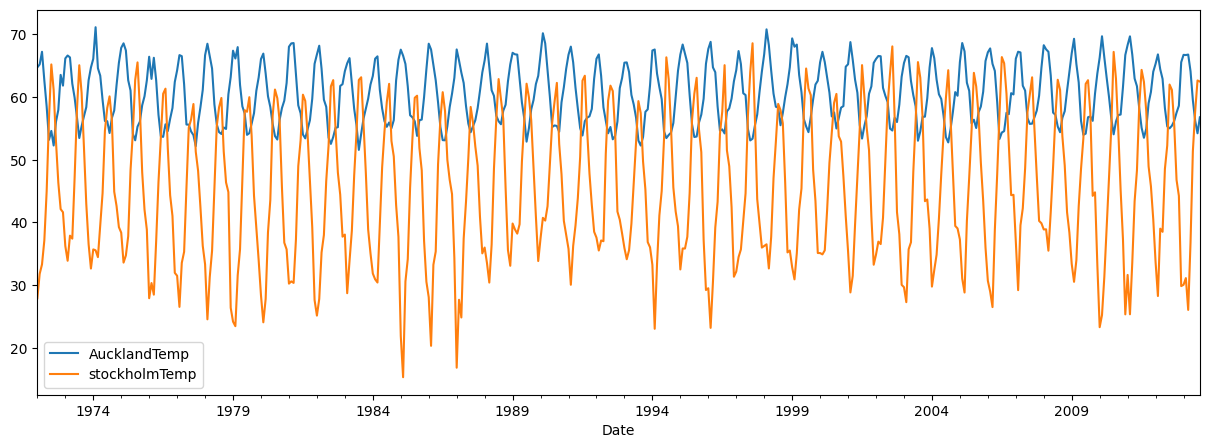

In [ ]:
joined_part.plot(figsize=(15, 5))

In [ ]:
Ntest = 12
train = joined_part.iloc[:-Ntest].copy()
test = joined_part.iloc[-Ntest:].copy()

In [ ]:
scaler_auckland = StandardScaler()
train['ScaledAuckland'] = scaler_auckland.fit_transform(train[['AucklandTemp']])
test['ScaledAuckland'] = scaler_auckland.transform(test[['AucklandTemp']])

In [ ]:
scaler_stockholm = StandardScaler()
train['ScaledStockholm'] = scaler_stockholm.fit_transform(train[['stockholmTemp']])
test['ScaledStockholm'] = scaler_stockholm.transform(test[['stockholmTemp']])

In [ ]:
train_idx = joined_part.index <= train.index[-1]
test_idx = joined_part.index > train.index[-1]

In [ ]:
joined_part.loc[train_idx, 'ScaledAuckland'] = train['ScaledAuckland']
joined_part.loc[test_idx, 'ScaledAuckland'] = test['ScaledAuckland']
joined_part.loc[train_idx, 'ScaledStockholm'] = train['ScaledStockholm']
joined_part.loc[test_idx, 'ScaledStockholm'] = test['ScaledStockholm']

<Axes: xlabel='Date'>

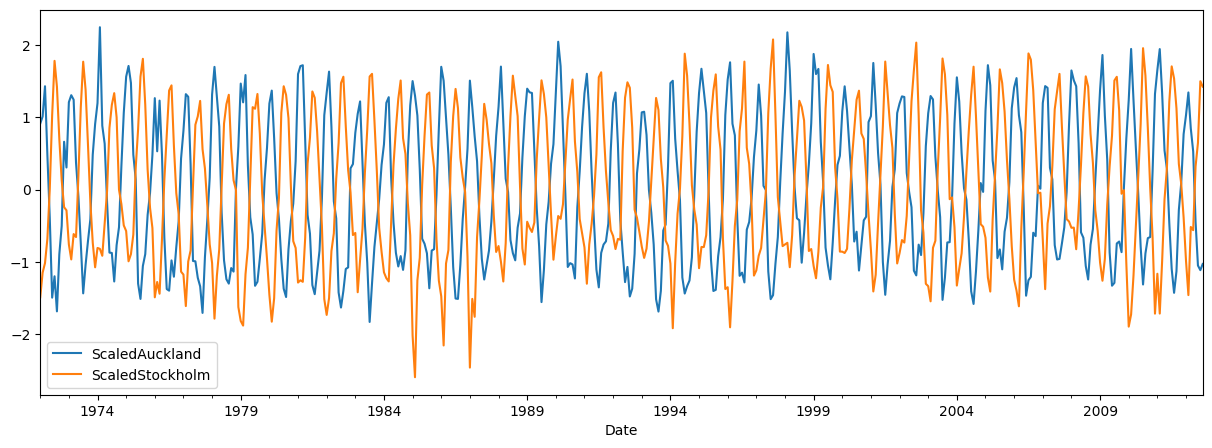

In [ ]:
cols = ['ScaledAuckland', 'ScaledStockholm']
train[cols].plot(figsize=(15, 5))

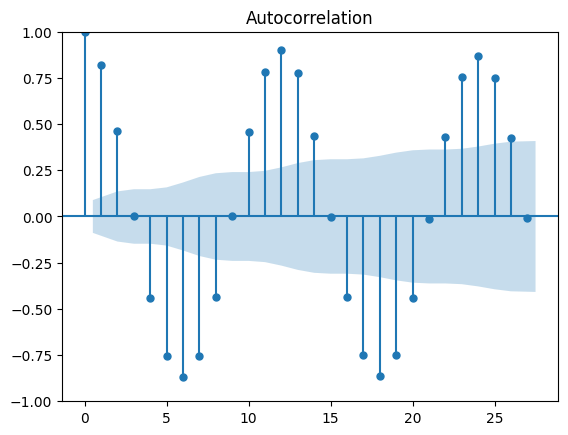

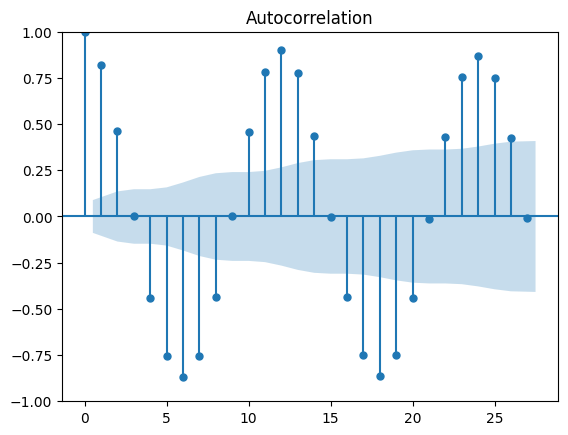

In [ ]:
plot_acf(train['ScaledAuckland'])

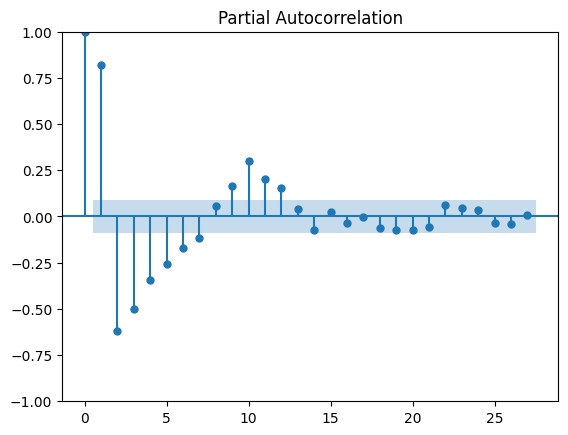

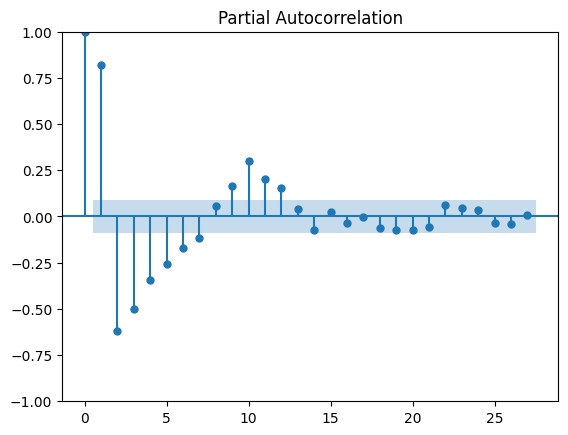

In [ ]:
plot_pacf(train['ScaledAuckland'])

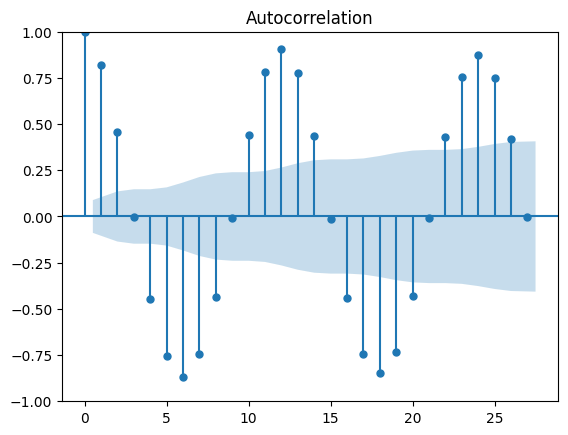

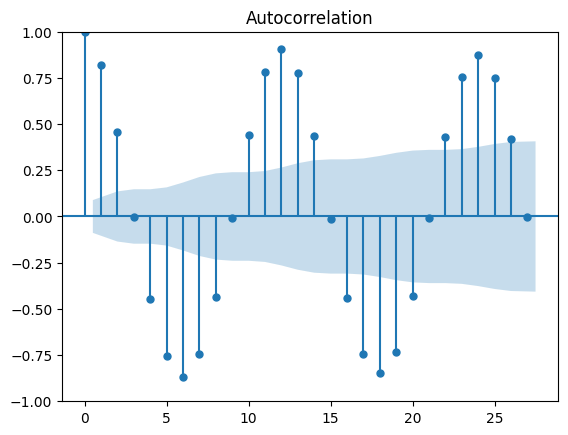

In [ ]:
plot_acf(train['ScaledStockholm'])

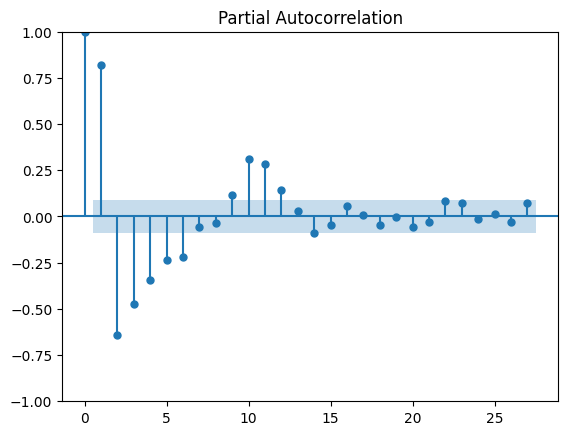

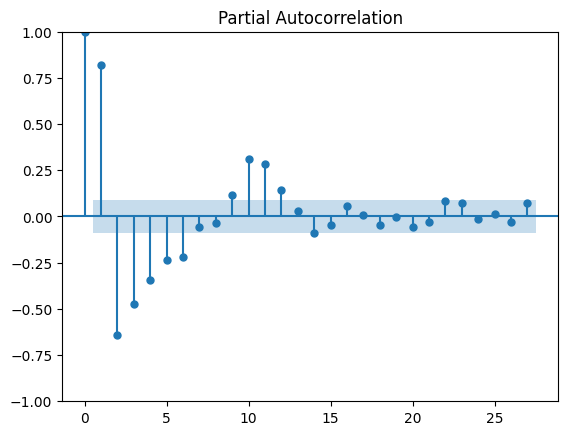

In [ ]:
plot_pacf(train['ScaledStockholm'])

In [ ]:
t0 = datetime.now()
model = VARMAX(train[cols], order=(10, 10))
res = model.fit(maxiter=100)
print('Duration:', datetime.now() - t0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Duration: 0:07:33.094237


In [ ]:
fcast = res.get_forecast(Ntest)

In [ ]:
res.fittedvalues['ScaledAuckland']

Date
1972-01-01   -0.008915
1972-02-01    0.835911
1972-03-01    0.717825
1972-04-01    0.818590
1972-05-01   -0.082818
                ...   
2012-04-01    0.513167
2012-05-01   -0.293116
2012-06-01   -1.064043
2012-07-01   -1.329765
2012-08-01   -1.065518
Freq: MS, Name: ScaledAuckland, Length: 488, dtype: float64

In [ ]:
joined_part.loc[train_idx, 'Train Pred Auckland'] = res.fittedvalues['ScaledAuckland']
joined_part.loc[test_idx, 'Test Pred Auckland'] = fcast.predicted_mean['ScaledAuckland']

<Axes: xlabel='Date'>

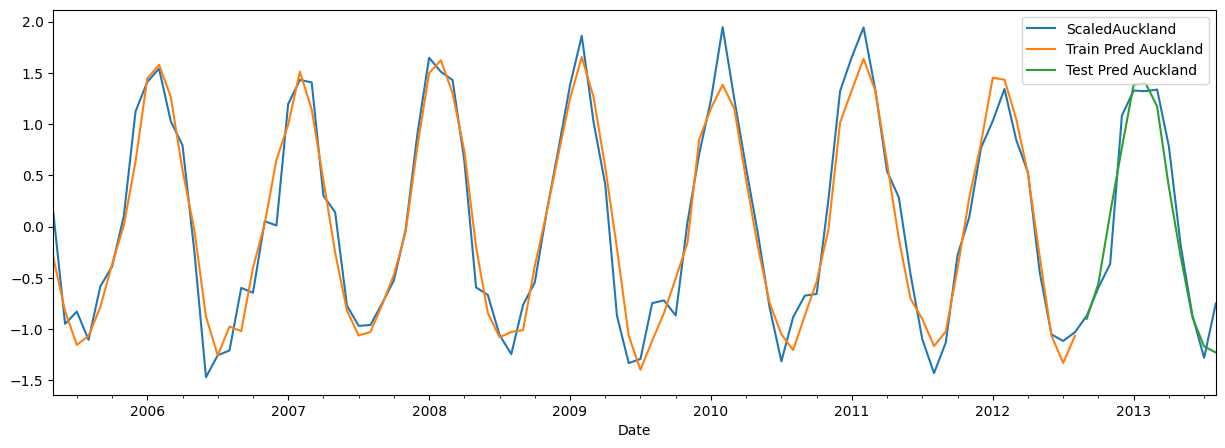

In [ ]:
plot_cols = ['ScaledAuckland', 'Train Pred Auckland', 'Test Pred Auckland']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15, 5))

In [ ]:
joined_part.loc[train_idx, 'Train Pred Stockholm'] = res.fittedvalues['ScaledStockholm']
joined_part.loc[test_idx, 'Test Pred Stockholm'] = fcast.predicted_mean['ScaledStockholm']

<Axes: xlabel='Date'>

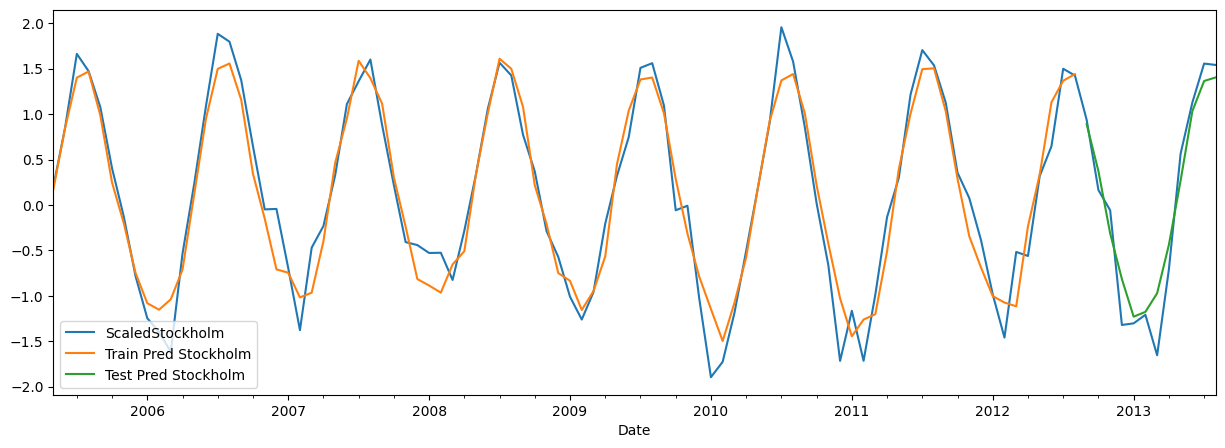

In [ ]:
plot_cols = ['ScaledStockholm', 'Train Pred Stockholm', 'Test Pred Stockholm']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15, 5))

In [ ]:
y_pred = joined_part.loc[train_idx, 'Train Pred Auckland']
y_true = joined_part.loc[train_idx, 'ScaledAuckland']
print('Auckland Train R^2:', r2_score(y_true, y_pred))

y_pred = joined_part.loc[test_idx, 'Test Pred Auckland']
y_true = joined_part.loc[test_idx, 'ScaledAuckland']
print('Auckland Test R^2:', r2_score(y_true, y_pred))

Auckland Train R^2: 0.9295007431235751
Auckland Test R^2: 0.9291941168492315


In [ ]:
y_pred = joined_part.loc[train_idx, 'Train Pred Stockholm']
y_true = joined_part.loc[train_idx, 'ScaledStockholm']
print('Stockholm Train R^2:', r2_score(y_true, y_pred))

y_pred = joined_part.loc[test_idx, 'Test Pred Stockholm']
y_true = joined_part.loc[test_idx, 'ScaledStockholm']
print('Stockholm Test R^2:', r2_score(y_true, y_pred))

Stockholm Train R^2: 0.9247020765505378
Stockholm Test R^2: 0.9310538802475459
